# Transfer Learning with EfficientNet

This notebook applies transfer learning using the EfficientNet base model to the Flowers Dataset from here: https://www.kaggle.com/datasets/olgabelitskaya/flower-color-images

It's a small dataset with only 210 images corresponding to 10 species of plants

I'm going to take an off-the-shelf model and build an image classifier that hopefully works on the dataset

This notebook includes:
- Data augmentation.
- Ensuring layers are frozen.
- Implementing early stopping.
- Then doing fine-tuning of the base model to see if we can boost performance


## Install Dependencies
Ensure `efficientnet==1.1.0` is installed.

In [1]:
!pip install efficientnet==1.1.0

## Imports

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from efficientnet import tfkeras as efficientnet  #EfficientNet from efficientnet.tfkeras
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import h5py   #for reading dataset file
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [3]:
seed = 1  #seed for reproducibility

## Load Data
Load datasets and check dimensions and data types. Images and floats so we need to convert into unsigned int8 - i.e. from 0-255

In [4]:
flowers_data = h5py.File('/drive/My Drive/SmallFlowers/FlowerColorImages.h5', 'r')
images_data = flowers_data['images'][:]
labels_data = flowers_data['labels'][:]

print('Images shape: ', images_data.shape)
print('Images type: ', images_data.dtype)
print('Images min: ', np.min(images_data), "max: ", np.max(images_data))
print('Labels shape: ', labels_data.shape)
print('Labels type: ', labels_data.dtype)
print('Unique labels: ', np.unique(labels_data))
print('Number of unique labels: ', len(np.unique(labels_data)))

images_data = images_data.astype(np.uint8)  # Convert to uint8
print('Images data type: ', images_data.dtype)

fNames = [
 'phlox','rose','calendula','iris','leucanthemum maximum','bellflower','viola','rudbeckia laciniata','peony','aquilegia'
]

Images shape:  (210, 128, 128, 3)
Images type:  float32
Images min:  0.0 max:  255.0
Labels shape:  (210,)
Labels type:  int64
Unique labels:  [0 1 2 3 4 5 6 7 8 9]
Number of unique labels:  10
Images data type:  uint8


As expected - 210 images 128x128x3 each. 10 output classes

## Dataset analysis

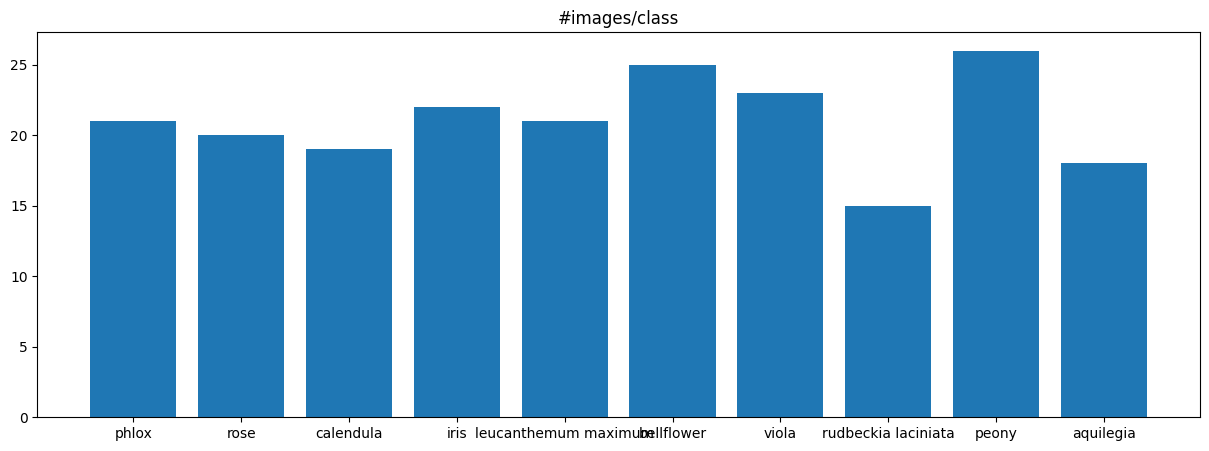

In [5]:
unique, counts = np.unique(labels_data, return_counts=True)
plt.figure(figsize=(15,5))
plt.title('#images/class')
ticks = np.arange(len(counts))
plt.bar(ticks, counts)
plt.xticks(ticks, fNames)
plt.show()

## Visualise the flowers

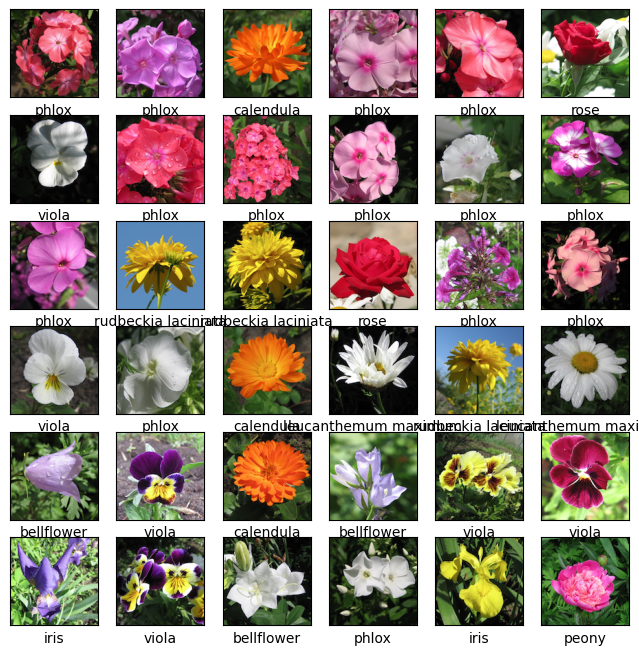

In [6]:
plt.figure(figsize=(8,8))

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images_data[i])
    plt.xlabel(fNames[labels_data[i]])
plt.show()

## Split the data

Split the data 50% train, 25% validation and 25% test

In [7]:
def shuffle(im, lab):
    rand = np.random.RandomState(seed)
    p = rand.permutation(im.shape[0])
    return im[p], lab[p]

X_data, y_data = shuffle(images_data, labels_data)

train_split_idx = int(0.5*X_data.shape[0])
val_split_idx = int(0.75*X_data.shape[0])
X_train, y_train = X_data[:train_split_idx], y_data[:train_split_idx]
X_val, y_val = X_data[train_split_idx:val_split_idx], y_data[train_split_idx:val_split_idx]
X_test, y_test = X_data[val_split_idx:], y_data[val_split_idx:]

## Data Preprocessing and Augmentation
`ImageDataGenerator` with augmentation for the training set and only preprocessing (ensures our inputs match what the pre-trained model expects) for validation and test sets.

preprocess_input functions correctly scale/normalise the data for input into the CNN


In [8]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=efficientnet.preprocess_input
)

val_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=efficientnet.preprocess_input
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=efficientnet.preprocess_input
)

For efficiency, use iterators to only load some images into memory at a time from the `flow` method

In [9]:
train_iterator = train_datagen.flow(X_train, y_train, batch_size=30)
val_iterator = val_datagen.flow(X_val, y_val, batch_size=len(y_val), shuffle=False) #set to flase as I want repeatable performance
test_iterator = test_datagen.flow(X_test, y_test, batch_size=len(y_test), shuffle=False)

## Model Setup
We'll use `EfficientNetB4` with `noisy-student` weights (https://www.kaggle.com/datasets/nobatgeldi/keras-efficientnetb3-noisy-student). We freeze all base model layers so we only train the top layers.

In [10]:
base_model = efficientnet.EfficientNetB4(
    weights='noisy-student',
    include_top=False,
    pooling='avg',
    input_shape=(128, 128, 3)
)
"""
weights_path = '/drive/My Drive/SmallFlowers/noisy_student_efficientnet_b4.h5'

base_model2 = EfficientNetB4(
    weights=weights_path,
    include_top=False,
    pooling='avg',
    input_shape=(128, 128, 3)
)
"""

#Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

#Add new custom top layers (this can be played with)
model = keras.models.Sequential([
    base_model,                          #Add the base model
    layers.Dropout(0.2),                 #Add Dropout
    #layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')  #Add custom Dense layer
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnet-b4 (Functional)         │ (None, 1792)                │      17,673,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1792)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          17,930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,691,746 (67.49 MB)

 Trainable params: 17,930 (70.04 KB)

 Non-trainable params: 17,673,816 (67.42 MB)

## Early Stopping
We use early stopping to prevent overfitting and restore the best weights.

In [11]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

callback_modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras', monitor='val_loss', save_best_only=True)

## Training the Model
Train for up to 30 epochs and use the validation iterator for monitoring.


In [12]:
history = model.fit(
    train_iterator,
    epochs=40,
    validation_data=val_iterator,
    callbacks=[early_stop, callback_modelcheckpoint]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 71s 11s/step - accuracy: 0.1713 - loss: 2.3115 - val_accuracy: 0.3654 - val_loss: 2.0149
Epoch 2/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.3699 - loss: 2.0106 - val_accuracy: 0.3654 - val_loss: 1.9070
Epoch 3/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 460ms/step - accuracy: 0.4455 - loss: 1.7651 - val_accuracy: 0.4038 - val_loss: 1.7759
Epoch 4/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 465ms/step - accuracy: 0.4264 - loss: 1.6725 - val_accuracy: 0.4808 - val_loss: 1.6494
Epoch 5/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step - accuracy: 0.4349 - loss: 1.6492 - val_accuracy: 0.5385 - val_loss: 1.5234
Epoch 6/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.6044 - loss: 1.3479 - val_accuracy: 0.5769 - val_loss: 1.4257
Epoch 7/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 552ms/step - accuracy: 0.6586 - loss: 1.2854 - val_accuracy: 0.6154 - val_loss: 1.3291
Epoch 8/40
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 445ms/step - accuracy: 0.6246 - loss: 1.3073 - val_accuracy: 0.6346 - val_loss: 1.2409
Epoc

In [13]:
from keras.models import load_model
saved_model = load_model('best_model.keras')

##  Test Set Evaluation


In [14]:
loss, accuracy = saved_model.evaluate(test_iterator)
print("Test Accuracy: ", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step - accuracy: 0.9057 - loss: 0.4443
Test Accuracy:  0.9056603908538818


## Plot Training History
Visualize the training and validation performance.

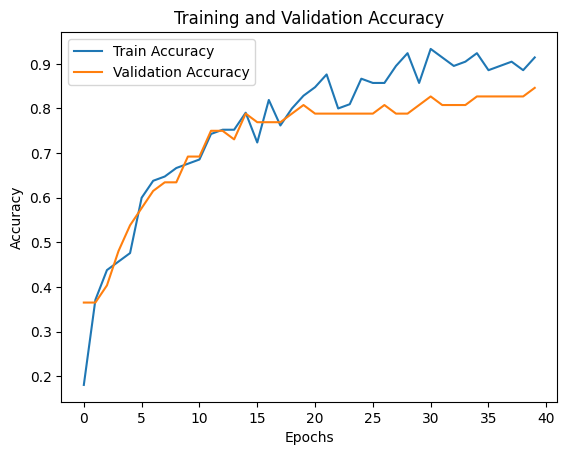

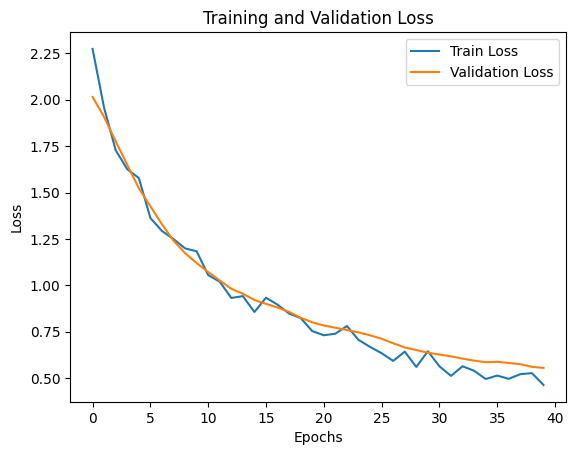

In [15]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [16]:
loss, accuracy = saved_model.evaluate(test_iterator)
print("Test Accuracy: ", accuracy)

pred_probs = saved_model.predict(test_iterator)
#Convert probability predictions to class indices
pred_classes = np.argmax(pred_probs, axis=1)

num_images_to_show = 25
plt.figure(figsize=(12, 12))
for i in range(num_images_to_show):
    plt.subplot(5,5,i+1)
    plt.imshow(X_test[i])
    actual_label = fNames[y_test[i]]
    predicted_label = fNames[pred_classes[i]]
    plt.title(f"Actual: {actual_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Classification Report:
                      precision    recall  f1-score   support

               phlox       0.62      0.83      0.71         6
                rose       1.00      1.00      1.00         5
           calendula       1.00      1.00      1.00         9
                iris       0.88      1.00      0.93         7
leucanthemum maximum       1.00      1.00      1.00         4
          bellflower       1.00      1.00      1.00         4
               viola       1.00      1.00      1.00         6
 rudbeckia laciniata       1.00      1.00      1.00         3
               peony       0.80      0.67      0.73         6
           aquilegia       1.00      0.33      0.50         3

            accuracy                           0.91        53
           macro avg       0.93      0.88      0.89        53
        weighted avg       0.92      0.91      0.90        53



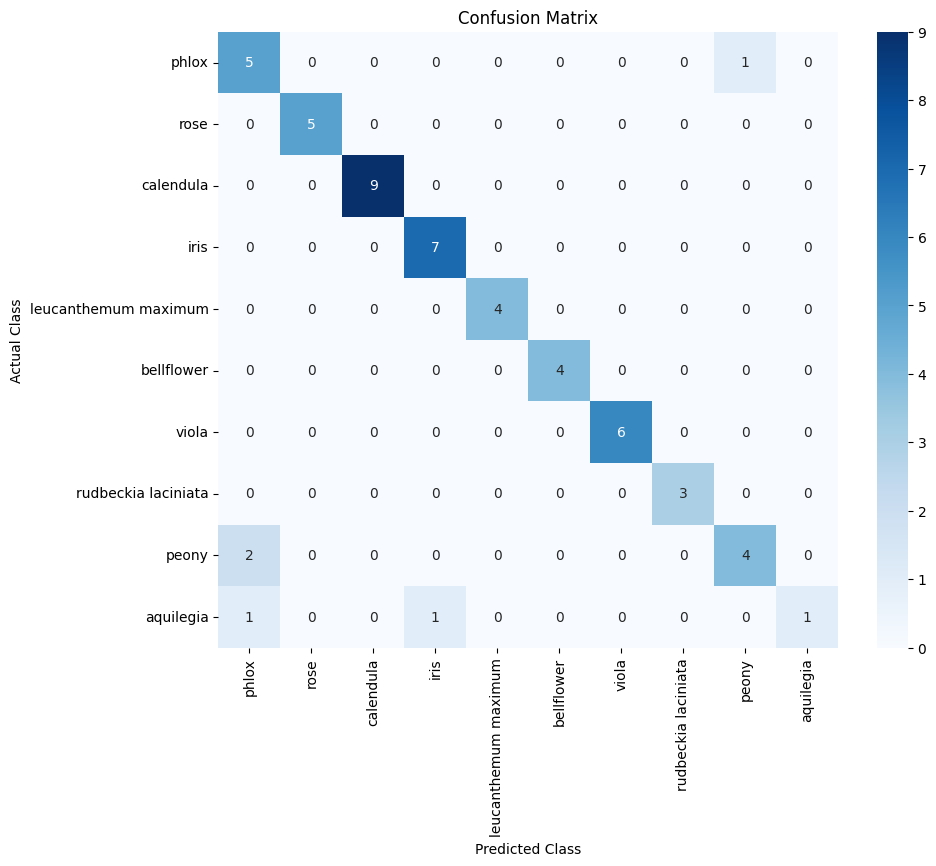

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

#Print classification report
print("Classification Report:")
true_classes = y_test
print(classification_report(true_classes, pred_classes, target_names=fNames))

#Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

#Plot confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=fNames, yticklabels=fNames)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix')
plt.show()

# Fine-tuning the base model

Let's look now at fune-tuning a portion of the base model. We'll have to go back and unfreeze a few layers and retrain again

In [18]:
#########################################################################################
#Let's say I want to unfreeze the top 20 layers of the base model
num_layers_to_unfreeze = 20

#Unfreeze the top num_layers_to_unfreeze layers
for layer in base_model.layers[-num_layers_to_unfreeze:]:
    layer.trainable = True

for i, layer in enumerate(base_model.layers):
    print(i, layer.name, layer.trainable)

0 input_layer False
1 stem_conv False
2 stem_bn False
3 stem_activation False
4 block1a_dwconv False
5 block1a_bn False
6 block1a_activation False
7 block1a_se_squeeze False
8 block1a_se_reshape False
9 block1a_se_reduce False
10 block1a_se_expand False
11 block1a_se_excite False
12 block1a_project_conv False
13 block1a_project_bn False
14 block1b_dwconv False
15 block1b_bn False
16 block1b_activation False
17 block1b_se_squeeze False
18 block1b_se_reshape False
19 block1b_se_reduce False
20 block1b_se_expand False
21 block1b_se_excite False
22 block1b_project_conv False
23 block1b_project_bn False
24 block1b_drop False
25 block1b_add False
26 block2a_expand_conv False
27 block2a_expand_bn False
28 block2a_expand_activation False
29 block2a_dwconv False
30 block2a_bn False
31 block2a_activation False
32 block2a_se_squeeze False
33 block2a_se_reshape False
34 block2a_se_reduce False
35 block2a_se_expand False
36 block2a_se_excite False
37 block2a_project_conv False
38 block2a_project_bn

In [19]:
#fineModel will be a copy of the original model
fineModel = tf.keras.models.clone_model(model)
fineModel.build(model.input_shape)
fineModel.set_weights(model.get_weights())

#Use an even lower learning rate for fine-tuning.
fineModel.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("Number of layers in the base model:", len(base_model.layers))
print("Number of trainable layers after unfreezing:", len([l for l in base_model.layers if l.trainable]))

model.summary()

Number of layers in the base model: 468
Number of trainable layers after unfreezing: 20


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnet-b4 (Functional)         │ (None, 1792)                │      17,673,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1792)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          17,930 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,727,608 (67.63 MB)

 Trainable params: 3,874,426 (14.78 MB)

 Non-trainable params: 13,817,320 (52.71 MB)

 Optimizer params: 35,862 (140.09 KB)

Fine tune the trainable portions of the model

In [20]:
fine_tune_epochs = 15
history_fine = fineModel.fit(
    train_iterator,
    epochs=fine_tune_epochs,
    validation_data=val_iterator
)

Epoch 1/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 70s 10s/step - accuracy: 0.8440 - loss: 0.7185 - val_accuracy: 0.8269 - val_loss: 0.5626
Epoch 2/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8138 - loss: 0.7510 - val_accuracy: 0.8269 - val_loss: 0.5692
Epoch 3/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.8559 - loss: 0.7362 - val_accuracy: 0.8269 - val_loss: 0.5724
Epoch 4/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8765 - loss: 0.6972 - val_accuracy: 0.8462 - val_loss: 0.5762
Epoch 5/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8747 - loss: 0.6537 - val_accuracy: 0.8654 - val_loss: 0.5802
Epoch 6/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8288 - loss: 0.7388 - val_accuracy: 0.8846 - val_loss: 0.5836
Epoch 7/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8707 - loss: 0.6422 - val_accuracy: 0.8846 - val_loss: 0.5857
Epoch 8/15
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8602 - loss: 0.6838 - val_accuracy: 0.8654 - val_loss: 0.5876


## Evaluate the original model

In [21]:
loss, accuracy = model.evaluate(test_iterator)
print("Fine-tuned model accuracy on test set:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9057 - loss: 0.4443
Fine-tuned model accuracy on test set: 0.9056603908538818


## Evaluate the fine-tuned model

In [22]:
loss, accuracy = fineModel.evaluate(test_iterator)
print("Fine-tuned model accuracy on test set:", accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.9623 - loss: 0.4765
Fine-tuned model accuracy on test set: 0.9622641801834106
